# 3.0: Figures for pre-study proposal

In [2]:
import os

import cartopy.crs as ccrs
from dotenv import find_dotenv, load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt

from src.conf.parse_params import config as cfg

load_dotenv(find_dotenv(), override=True)
PROJECT_ROOT = os.environ["PROJECT_ROOT"]

os.chdir(PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

Load the GBIF data clipped to the Sentinel-2 extent.

In [3]:
gbif = gpd.read_parquet(cfg["gbif"]["clipped"])
gbif.head()

,species,geometry
0,Alchemilla monticola,POINT (464536.685 5234518.402)
1,Festuca trachyphylla,POINT (464557.440 5234586.533)
2,Aegopodium podagraria,POINT (449706.899 5234492.183)
3,Erigeron annuus,POINT (449502.208 5234560.493)
4,Medicago sativa,POINT (449609.735 5235128.954)


Load the NaturalEarth high-res world vector file and get the geometry for Germany.

In [4]:
world = gpd.read_file(
    "./data/raw/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
)
# get germany (where featurecla == 'Admin-0 country' and SOVEREIGNT == 'Germany')
germany = world[(world["featurecla"] == "Admin-0 country") & (world["SOVEREIGNT"] == "Germany")]

Reproject the GBIF data to EPSG: 4326 and clip it the extent of Germany's borders.

In [5]:
gbif = gbif.to_crs(world.crs)
# germany = germany.to_crs(gbif.crs)

# Clip gbif to germany boundary
gbif = gpd.clip(gbif, germany)

In [ ]:
gbif_UTM32N = gbif.to_crs(epsg=32632)
germany_UTM32N = germany.to_crs(epsg=32632)

Plot a density map of GBIF observations across Germany at 1km resolution

In [78]:
import cartopy.crs as ccrs
import seaborn as sns
from matplotlib import colorbar

from cartopy.mpl.geoaxes import GeoAxes

def gbif_hexbin(gbif: gpd.GeoDataFrame, germany: gpd.GeoDataFrame, ax: GeoAxes, context="paper", font_scale=1):
    # Create the hexbin plot
    hb = ax.hexbin(
        gbif.geometry.x,
        gbif.geometry.y,
        gridsize=80,
        cmap="cool",
        bins="log",
        mincnt=20,
        transform=ccrs.UTM(32),
    )
    # Add colorbar to the axis (we don't have access to the fig or plt)
    cbar = plt.colorbar(hb, ax=ax, orientation="vertical")
    cbar.set_label("Number of GBIF observations\n(all species)")

    # Overlay the map of Germany
    germany.boundary.plot(ax=ax, color="black", linewidth=1)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False  # Hide the top labels
    gl.right_labels = False  # Hide the right labels

    # Get the centers of the hexagons
    centers = hb.get_offsets()

    return ax, centers

def top_10_barplot(gbif: gpd.GeoDataFrame, ax: GeoAxes, context="paper", font_scale=1):
    # Create a barplot of the top 10 species
    top_10 = gbif["species"].value_counts().head(10)
    top_10.plot(kind="bar", ax=ax, color=plt.cm.cool(top_10 / top_10.max()))
    # ax.invert_yaxis()  # Invert the y-axis to have the species with the most observations at the top
    
    # reverse the x axis and move the y ticks and label to the right
    ax.invert_xaxis()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.set_xlabel("Top 10 species")
    ax.set_ylabel("Number of observations")

    # rotate the x-axis ticks for this axis only
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    return ax

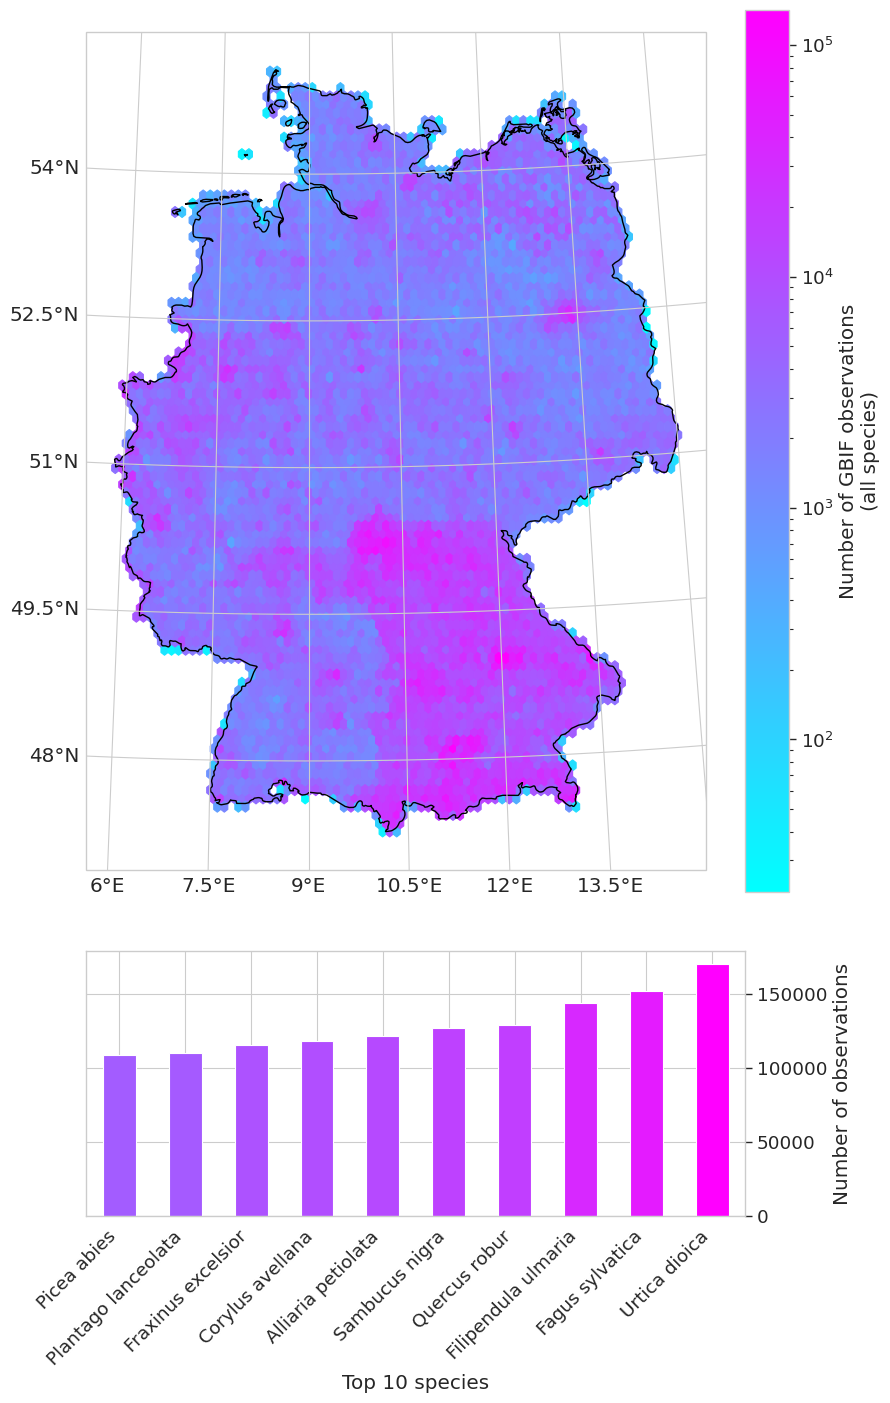

In [94]:
import cartopy.crs as ccrs
import seaborn as sns
from matplotlib import colorbar, gridspec
from cartopy.mpl.geoaxes import GeoAxes

with sns.plotting_context("paper", font_scale=1.5):
    # Create a GridSpec with two rows and one column
    gs = gridspec.GridSpec(2, 1, height_ratios=[7, 3])

    # Create the figure
    fig = plt.figure(figsize=(10, 18))

    # Create the hexbin plot in the first row
    ax1= plt.subplot(gs[0], projection=ccrs.UTM(32))
    ax1, centers = gbif_hexbin(gbif_UTM32N, germany_UTM32N, ax1)

    # Create the barplot in the second row
    ax2 = plt.subplot(gs[1])
    ax2 = top_10_barplot(gbif, ax2)

    # Reduce the width of ax2 just a bit
    pos2 = ax2.get_position()
    ax2.set_position([pos2.x0, pos2.y0 + 0.1, pos2.width * 0.85, pos2.height * 0.7])

    # add some padding between the plot and the colorbar
    # plt.tight_layout()

    # Save the plot
    plt.savefig(
        "reports/figures/gbif_observations_germany.pdf", bbox_inches="tight", dpi=300
    )

    plt.show()

Calculate some hexagon stats

In [86]:
import numpy as np

# Calculate the width and height in hexagons
width = np.ptp(centers[:, 0]) # / np.sqrt(3)  # The factor of sqrt(3) comes from the geometry of the hexagons
height = np.ptp(centers[:, 1])

num_wide = len(np.unique(centers[:, 1]))
num_high = len(np.unique(centers[:, 0]))

print(f'Width in hexagons: {width / 1000}km')
print(f'Height in hexagons: {height / 1000}km')

print(f'Number of hexagons wide: {num_wide}')
print(f'Number of hexagons high: {num_high}')

hex_width_km = (width / 1000) / num_wide
hex_height_km = (height / 1000) / num_high

print(f'Hexagon width: {hex_width_km}km')
print(f'Hexagon height: {hex_height_km}km')

Width in hexagons: 640.085731223887km
Height in hexagons: 863.9917879709127km
Number of hexagons wide: 93
Number of hexagons high: 161
Hexagon width: 6.882642271224592km
Hexagon height: 5.366408620937346km


In [89]:
# hex side length
s = (np.max(gbif_UTM32N.geometry.x) - np.min(gbif_UTM32N.geometry.x)) / 80

# hexagon area
A = 3/2 * np.sqrt(3) * s**2

print(f"Area of a hexagon in km: {A / 1e6}km^2")

Area of a hexagon in km: 166.32142709566102km^2


In [90]:
np.sqrt(A / 1e6)

12.896566484753258